# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [6]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [7]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [8]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [9]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [10]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

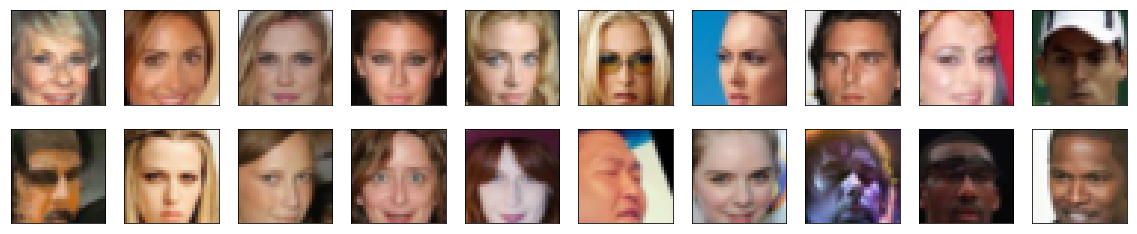

In [11]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = (x * (feature_range[1] - feature_range[0])) + feature_range[0]
    return x


In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9059)
Max:  tensor(0.9451)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# From CycleGAN notebook
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=not batch_norm)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)

        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, activate=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                     stride, padding, bias=not batch_norm))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if activate:
        layers.append(nn.ReLU())    
        
    return nn.Sequential(*layers)

In [18]:
from collections import OrderedDict

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.n_layers = 5
        self.conv_t_w_in = int(32/2**self.n_layers)
        self.conv_t_dim_in = conv_dim * self.conv_t_w_in
        
        self.fc1 = nn.Linear(z_size, self.conv_t_dim_in*(self.conv_t_w_in**2))        
        
        self.conv_t_in = deconv(self.conv_t_dim_in, conv_dim * (self.n_layers - 1))

        deep_conv_t_layers = []
        for layer in reversed(range(2, self.n_layers)):
            deep_conv_t_layers.append((f'conv_t{abs(layer - self.n_layers)}', 
                                       deconv(conv_dim * layer, conv_dim * (layer - 1))))
        
        self.deep_conv_t = nn.Sequential(OrderedDict(deep_conv_t_layers))
        self.conv_t_out = deconv(conv_dim, 3, batch_norm=False, activate=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        
        x = x.view(x.size(0), self.conv_t_dim_in, self.conv_t_w_in, self.conv_t_w_in)
        
        x = self.conv_t_in(x)
        x = self.deep_conv_t(x)
        x = torch.tanh(self.conv_t_out(x))

        return x
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [19]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [21]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (conv_t_in): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (deep_conv_t): Sequential(
    (conv_t1): Sequential(
      (0): ConvTranspose2d(256, 192, kernel_size

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [23]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    D_out = D_out.squeeze()
    target = torch.ones(D_out.size())
    if smooth:
        target = target * 0.9
    if train_on_gpu:
        target = target.cuda()
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    D_out = D_out.squeeze()
    target = torch.zeros(D_out.size())
    if train_on_gpu:
        target = target.cuda()
    loss = F.binary_cross_entropy_with_logits(D_out, target)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [24]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [25]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            if train_on_gpu:
                real_images = real_images.cuda()

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            d_real_out = D(real_images)
            d_real_loss = real_loss(d_real_out, True)
            
            fake_images = G(fixed_z)
            d_fake_out = D(fake_images)
            d_fake_loss = fake_loss(d_fake_out)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            fake_images = G(fixed_z)
            g_fake_out = D(fake_images)
            
            g_loss = real_loss(g_fake_out)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [57]:
# set number of epochs 
#n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
#losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.3110 | g_loss: 4.5113
Epoch [    1/  100] | d_loss: 0.1733 | g_loss: 1.1048
Epoch [    1/  100] | d_loss: 0.1544 | g_loss: 1.7701
Epoch [    1/  100] | d_loss: 0.3221 | g_loss: 0.9771
Epoch [    1/  100] | d_loss: 0.0386 | g_loss: 0.9625
Epoch [    1/  100] | d_loss: 0.1346 | g_loss: 0.6973
Epoch [    1/  100] | d_loss: 0.4912 | g_loss: 0.4752
Epoch [    1/  100] | d_loss: 0.2763 | g_loss: 0.7556
Epoch [    1/  100] | d_loss: 0.1786 | g_loss: 1.2162
Epoch [    1/  100] | d_loss: 0.1298 | g_loss: 1.3570
Epoch [    1/  100] | d_loss: 0.1130 | g_loss: 0.9161
Epoch [    1/  100] | d_loss: 0.0553 | g_loss: 1.1629
Epoch [    1/  100] | d_loss: 0.0669 | g_loss: 1.1648
Epoch [    1/  100] | d_loss: 0.2611 | g_loss: 0.7870
Epoch [    1/  100] | d_loss: 0.0960 | g_loss: 1.3980
Epoch [    1/  100] | d_loss: 0.1031 | g_loss: 1.3709
Epoch [    1/  100] | d_loss: 0.0845 | g_loss: 1.1987
Epoch [    1/  100] | d_loss: 0.1226 | g_loss: 1.5808
Epoch [    1/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.0151 | g_loss: 0.9380
Epoch [    9/  100] | d_loss: 0.0144 | g_loss: 1.0296
Epoch [    9/  100] | d_loss: 0.0220 | g_loss: 1.1559
Epoch [    9/  100] | d_loss: 0.0108 | g_loss: 1.1378
Epoch [    9/  100] | d_loss: 0.0106 | g_loss: 1.1004
Epoch [    9/  100] | d_loss: 0.0055 | g_loss: 1.1029
Epoch [    9/  100] | d_loss: 0.0957 | g_loss: 0.6839
Epoch [    9/  100] | d_loss: 0.0059 | g_loss: 1.0567
Epoch [    9/  100] | d_loss: 0.0076 | g_loss: 1.0156
Epoch [    9/  100] | d_loss: 0.0992 | g_loss: 0.8105
Epoch [    9/  100] | d_loss: 0.0409 | g_loss: 0.8830
Epoch [   10/  100] | d_loss: 0.0110 | g_loss: 1.0458
Epoch [   10/  100] | d_loss: 0.0590 | g_loss: 1.0088
Epoch [   10/  100] | d_loss: 0.0139 | g_loss: 0.8742
Epoch [   10/  100] | d_loss: 0.0360 | g_loss: 1.0753
Epoch [   10/  100] | d_loss: 0.0142 | g_loss: 1.1749
Epoch [   10/  100] | d_loss: 0.0261 | g_loss: 1.0700
Epoch [   10/  100] | d_loss: 0.0080 | g_loss: 0.9644
Epoch [   10/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.0149 | g_loss: 0.9817
Epoch [   17/  100] | d_loss: 0.0084 | g_loss: 0.9508
Epoch [   17/  100] | d_loss: 0.0207 | g_loss: 1.0709
Epoch [   17/  100] | d_loss: 0.0006 | g_loss: 1.0052
Epoch [   17/  100] | d_loss: 0.0132 | g_loss: 0.9831
Epoch [   17/  100] | d_loss: 0.0143 | g_loss: 1.0314
Epoch [   17/  100] | d_loss: 0.0243 | g_loss: 1.0353
Epoch [   17/  100] | d_loss: 0.0207 | g_loss: 1.1300
Epoch [   17/  100] | d_loss: 0.0102 | g_loss: 0.9550
Epoch [   17/  100] | d_loss: 0.0186 | g_loss: 0.9613
Epoch [   17/  100] | d_loss: 0.0518 | g_loss: 1.0066
Epoch [   18/  100] | d_loss: 0.1381 | g_loss: 0.9655
Epoch [   18/  100] | d_loss: 0.0129 | g_loss: 0.9643
Epoch [   18/  100] | d_loss: 0.0038 | g_loss: 1.0185
Epoch [   18/  100] | d_loss: 0.0089 | g_loss: 1.0434
Epoch [   18/  100] | d_loss: 0.0230 | g_loss: 1.0930
Epoch [   18/  100] | d_loss: 0.0036 | g_loss: 1.0081
Epoch [   18/  100] | d_loss: 0.1067 | g_loss: 0.8165
Epoch [   18/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.0011 | g_loss: 1.0068
Epoch [   25/  100] | d_loss: 0.0012 | g_loss: 1.0004
Epoch [   25/  100] | d_loss: 0.0018 | g_loss: 0.9663
Epoch [   25/  100] | d_loss: 0.1097 | g_loss: 1.3771
Epoch [   25/  100] | d_loss: 0.0329 | g_loss: 1.1722
Epoch [   25/  100] | d_loss: 0.0555 | g_loss: 0.8470
Epoch [   25/  100] | d_loss: 0.0142 | g_loss: 0.9223
Epoch [   25/  100] | d_loss: 0.0812 | g_loss: 0.8121
Epoch [   25/  100] | d_loss: 0.0060 | g_loss: 1.1950
Epoch [   25/  100] | d_loss: 0.0168 | g_loss: 1.0160
Epoch [   25/  100] | d_loss: 0.0082 | g_loss: 1.0583
Epoch [   26/  100] | d_loss: 0.0049 | g_loss: 1.0391
Epoch [   26/  100] | d_loss: 0.0039 | g_loss: 0.9772
Epoch [   26/  100] | d_loss: 0.0247 | g_loss: 1.0859
Epoch [   26/  100] | d_loss: 0.0098 | g_loss: 1.0275
Epoch [   26/  100] | d_loss: 0.0071 | g_loss: 1.0201
Epoch [   26/  100] | d_loss: 0.0087 | g_loss: 1.0275
Epoch [   26/  100] | d_loss: 0.2629 | g_loss: 0.9868
Epoch [   26/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.0040 | g_loss: 1.0412
Epoch [   33/  100] | d_loss: 0.0027 | g_loss: 1.0276
Epoch [   33/  100] | d_loss: 0.0027 | g_loss: 0.9918
Epoch [   33/  100] | d_loss: 0.0687 | g_loss: 0.7885
Epoch [   33/  100] | d_loss: 0.0007 | g_loss: 1.0183
Epoch [   33/  100] | d_loss: 0.0034 | g_loss: 0.9999
Epoch [   33/  100] | d_loss: 0.0031 | g_loss: 0.9882
Epoch [   33/  100] | d_loss: 0.0010 | g_loss: 0.9761
Epoch [   33/  100] | d_loss: 0.0030 | g_loss: 1.0031
Epoch [   33/  100] | d_loss: 0.0010 | g_loss: 1.0023
Epoch [   33/  100] | d_loss: 0.0088 | g_loss: 0.9635
Epoch [   34/  100] | d_loss: 0.0200 | g_loss: 0.9984
Epoch [   34/  100] | d_loss: 0.0026 | g_loss: 1.0175
Epoch [   34/  100] | d_loss: 0.0035 | g_loss: 0.9858
Epoch [   34/  100] | d_loss: 0.0015 | g_loss: 1.1063
Epoch [   34/  100] | d_loss: 0.0006 | g_loss: 1.0032
Epoch [   34/  100] | d_loss: 0.0013 | g_loss: 0.9871
Epoch [   34/  100] | d_loss: 0.0003 | g_loss: 0.9927
Epoch [   34/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0010 | g_loss: 0.9975
Epoch [   41/  100] | d_loss: 0.0120 | g_loss: 0.9596
Epoch [   41/  100] | d_loss: 0.0010 | g_loss: 0.9713
Epoch [   41/  100] | d_loss: 0.0023 | g_loss: 1.0135
Epoch [   41/  100] | d_loss: 0.0038 | g_loss: 1.0103
Epoch [   41/  100] | d_loss: 0.0004 | g_loss: 1.0037
Epoch [   41/  100] | d_loss: 0.0004 | g_loss: 1.0118
Epoch [   41/  100] | d_loss: 0.0005 | g_loss: 0.9937
Epoch [   41/  100] | d_loss: 0.0012 | g_loss: 0.9999
Epoch [   41/  100] | d_loss: 0.0045 | g_loss: 0.9426
Epoch [   41/  100] | d_loss: 0.0021 | g_loss: 1.0203
Epoch [   42/  100] | d_loss: 0.0002 | g_loss: 1.0037
Epoch [   42/  100] | d_loss: 0.0012 | g_loss: 0.9934
Epoch [   42/  100] | d_loss: 0.0035 | g_loss: 0.9647
Epoch [   42/  100] | d_loss: 0.0020 | g_loss: 1.0265
Epoch [   42/  100] | d_loss: 0.0034 | g_loss: 0.9681
Epoch [   42/  100] | d_loss: 0.0048 | g_loss: 0.9597
Epoch [   42/  100] | d_loss: 0.0005 | g_loss: 1.0056
Epoch [   42/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.0002 | g_loss: 0.9918
Epoch [   49/  100] | d_loss: 0.0006 | g_loss: 0.9993
Epoch [   49/  100] | d_loss: 0.0103 | g_loss: 1.1801
Epoch [   49/  100] | d_loss: 0.0005 | g_loss: 1.0027
Epoch [   49/  100] | d_loss: 0.0055 | g_loss: 1.1064
Epoch [   49/  100] | d_loss: 0.0020 | g_loss: 1.0107
Epoch [   49/  100] | d_loss: 0.0015 | g_loss: 1.0050
Epoch [   49/  100] | d_loss: 0.0305 | g_loss: 0.9410
Epoch [   49/  100] | d_loss: 0.0114 | g_loss: 0.9975
Epoch [   49/  100] | d_loss: 0.0075 | g_loss: 1.0762
Epoch [   49/  100] | d_loss: 0.0012 | g_loss: 1.0156
Epoch [   50/  100] | d_loss: 0.0042 | g_loss: 1.0225
Epoch [   50/  100] | d_loss: 0.0027 | g_loss: 0.9981
Epoch [   50/  100] | d_loss: 0.0011 | g_loss: 1.0058
Epoch [   50/  100] | d_loss: 0.0007 | g_loss: 1.0020
Epoch [   50/  100] | d_loss: 0.0090 | g_loss: 0.9946
Epoch [   50/  100] | d_loss: 0.0011 | g_loss: 0.9995
Epoch [   50/  100] | d_loss: 0.0125 | g_loss: 0.9391
Epoch [   50/  100] | d_loss

Epoch [   57/  100] | d_loss: 0.0024 | g_loss: 1.0068
Epoch [   57/  100] | d_loss: 0.0012 | g_loss: 1.0089
Epoch [   57/  100] | d_loss: 0.0088 | g_loss: 0.9523
Epoch [   57/  100] | d_loss: 0.0004 | g_loss: 1.0093
Epoch [   57/  100] | d_loss: 0.0006 | g_loss: 0.9978
Epoch [   57/  100] | d_loss: 0.0002 | g_loss: 1.0115
Epoch [   57/  100] | d_loss: 0.0003 | g_loss: 1.0041
Epoch [   57/  100] | d_loss: 0.0004 | g_loss: 0.9978
Epoch [   57/  100] | d_loss: 0.0005 | g_loss: 0.9883
Epoch [   57/  100] | d_loss: 0.0006 | g_loss: 0.9923
Epoch [   57/  100] | d_loss: 0.0009 | g_loss: 1.0146
Epoch [   58/  100] | d_loss: 0.0007 | g_loss: 1.0024
Epoch [   58/  100] | d_loss: 0.0008 | g_loss: 0.9756
Epoch [   58/  100] | d_loss: 0.0001 | g_loss: 0.9994
Epoch [   58/  100] | d_loss: 0.0014 | g_loss: 0.9831
Epoch [   58/  100] | d_loss: 0.0010 | g_loss: 1.0141
Epoch [   58/  100] | d_loss: 0.0048 | g_loss: 0.9523
Epoch [   58/  100] | d_loss: 0.0009 | g_loss: 0.9912
Epoch [   58/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.0012 | g_loss: 0.9985
Epoch [   65/  100] | d_loss: 0.0007 | g_loss: 1.0024
Epoch [   65/  100] | d_loss: 0.0012 | g_loss: 1.0230
Epoch [   65/  100] | d_loss: 0.0040 | g_loss: 1.0148
Epoch [   65/  100] | d_loss: 0.0032 | g_loss: 1.0135
Epoch [   65/  100] | d_loss: 0.0003 | g_loss: 0.9901
Epoch [   65/  100] | d_loss: 0.0141 | g_loss: 0.9293
Epoch [   65/  100] | d_loss: 0.0018 | g_loss: 0.9955
Epoch [   65/  100] | d_loss: 0.0005 | g_loss: 1.0008
Epoch [   65/  100] | d_loss: 0.0010 | g_loss: 0.9836
Epoch [   65/  100] | d_loss: 0.0003 | g_loss: 0.9957
Epoch [   66/  100] | d_loss: 0.0024 | g_loss: 1.0168
Epoch [   66/  100] | d_loss: 0.0012 | g_loss: 0.9915
Epoch [   66/  100] | d_loss: 0.0028 | g_loss: 0.9899
Epoch [   66/  100] | d_loss: 0.0010 | g_loss: 0.9996
Epoch [   66/  100] | d_loss: 0.0006 | g_loss: 0.9930
Epoch [   66/  100] | d_loss: 0.0014 | g_loss: 0.9806
Epoch [   66/  100] | d_loss: 0.0003 | g_loss: 1.0018
Epoch [   66/  100] | d_loss

Epoch [   73/  100] | d_loss: 0.0004 | g_loss: 1.0103
Epoch [   73/  100] | d_loss: 0.0004 | g_loss: 1.0094
Epoch [   73/  100] | d_loss: 0.0005 | g_loss: 1.0149
Epoch [   73/  100] | d_loss: 0.0008 | g_loss: 0.9969
Epoch [   73/  100] | d_loss: 0.0003 | g_loss: 1.0036
Epoch [   73/  100] | d_loss: 0.0004 | g_loss: 1.0013
Epoch [   73/  100] | d_loss: 0.0002 | g_loss: 1.0052
Epoch [   73/  100] | d_loss: 0.0020 | g_loss: 1.0120
Epoch [   73/  100] | d_loss: 0.0004 | g_loss: 1.0024
Epoch [   73/  100] | d_loss: 0.0020 | g_loss: 1.0161
Epoch [   73/  100] | d_loss: 0.0007 | g_loss: 1.0064
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 0.9936
Epoch [   74/  100] | d_loss: 0.0002 | g_loss: 0.9989
Epoch [   74/  100] | d_loss: 0.0005 | g_loss: 0.9951
Epoch [   74/  100] | d_loss: 0.0040 | g_loss: 0.9985
Epoch [   74/  100] | d_loss: 0.0039 | g_loss: 1.0051
Epoch [   74/  100] | d_loss: 0.0006 | g_loss: 1.0101
Epoch [   74/  100] | d_loss: 0.0006 | g_loss: 0.9983
Epoch [   74/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.0007 | g_loss: 1.0005
Epoch [   81/  100] | d_loss: 0.0004 | g_loss: 1.0021
Epoch [   81/  100] | d_loss: 0.0002 | g_loss: 1.0026
Epoch [   81/  100] | d_loss: 0.0006 | g_loss: 1.0020
Epoch [   81/  100] | d_loss: 0.0002 | g_loss: 0.9940
Epoch [   81/  100] | d_loss: 0.0004 | g_loss: 1.0043
Epoch [   81/  100] | d_loss: 0.0005 | g_loss: 0.9898
Epoch [   81/  100] | d_loss: 0.0048 | g_loss: 0.9851
Epoch [   81/  100] | d_loss: 0.0214 | g_loss: 1.1407
Epoch [   81/  100] | d_loss: 0.0005 | g_loss: 0.9893
Epoch [   81/  100] | d_loss: 0.0001 | g_loss: 1.0017
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 1.0054
Epoch [   82/  100] | d_loss: 0.0002 | g_loss: 1.0137
Epoch [   82/  100] | d_loss: 0.0007 | g_loss: 0.9999
Epoch [   82/  100] | d_loss: 0.0004 | g_loss: 0.9995
Epoch [   82/  100] | d_loss: 0.0005 | g_loss: 1.0135
Epoch [   82/  100] | d_loss: 0.0000 | g_loss: 1.0084
Epoch [   82/  100] | d_loss: 0.0002 | g_loss: 0.9990
Epoch [   82/  100] | d_loss

Epoch [   89/  100] | d_loss: 0.0004 | g_loss: 0.9997
Epoch [   89/  100] | d_loss: 0.0016 | g_loss: 1.0080
Epoch [   89/  100] | d_loss: 0.0015 | g_loss: 0.9675
Epoch [   89/  100] | d_loss: 0.0005 | g_loss: 0.9984
Epoch [   89/  100] | d_loss: 0.0005 | g_loss: 1.0048
Epoch [   89/  100] | d_loss: 0.0004 | g_loss: 1.0038
Epoch [   89/  100] | d_loss: 0.0082 | g_loss: 0.9938
Epoch [   89/  100] | d_loss: 0.0035 | g_loss: 1.0161
Epoch [   89/  100] | d_loss: 0.0006 | g_loss: 0.9899
Epoch [   89/  100] | d_loss: 0.0060 | g_loss: 0.9760
Epoch [   89/  100] | d_loss: 0.0005 | g_loss: 0.9972
Epoch [   90/  100] | d_loss: 0.0007 | g_loss: 1.0018
Epoch [   90/  100] | d_loss: 0.0004 | g_loss: 0.9990
Epoch [   90/  100] | d_loss: 0.0183 | g_loss: 0.9633
Epoch [   90/  100] | d_loss: 0.0010 | g_loss: 1.0039
Epoch [   90/  100] | d_loss: 0.0357 | g_loss: 0.9607
Epoch [   90/  100] | d_loss: 0.0001 | g_loss: 1.0256
Epoch [   90/  100] | d_loss: 0.0006 | g_loss: 1.0030
Epoch [   90/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.0007 | g_loss: 0.9973
Epoch [   97/  100] | d_loss: 0.0010 | g_loss: 1.0081
Epoch [   97/  100] | d_loss: 0.0003 | g_loss: 1.0011
Epoch [   97/  100] | d_loss: 0.0006 | g_loss: 0.9998
Epoch [   97/  100] | d_loss: 0.0002 | g_loss: 0.9985
Epoch [   97/  100] | d_loss: 0.0001 | g_loss: 0.9967
Epoch [   97/  100] | d_loss: 0.0067 | g_loss: 0.9837
Epoch [   97/  100] | d_loss: 0.0008 | g_loss: 1.0342
Epoch [   97/  100] | d_loss: 0.0002 | g_loss: 0.9933
Epoch [   97/  100] | d_loss: 0.0008 | g_loss: 0.9957
Epoch [   97/  100] | d_loss: 0.0003 | g_loss: 1.0093
Epoch [   98/  100] | d_loss: 0.0007 | g_loss: 1.0054
Epoch [   98/  100] | d_loss: 0.0006 | g_loss: 1.0041
Epoch [   98/  100] | d_loss: 0.0004 | g_loss: 1.0481
Epoch [   98/  100] | d_loss: 0.0006 | g_loss: 1.0018
Epoch [   98/  100] | d_loss: 0.0003 | g_loss: 0.9856
Epoch [   98/  100] | d_loss: 0.0002 | g_loss: 0.9943
Epoch [   98/  100] | d_loss: 0.0005 | g_loss: 0.9911
Epoch [   98/  100] | d_loss

In [216]:
#!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py


In [39]:
from workspace_utils import active_session
# set number of epochs 
n_epochs = 80


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   80] | d_loss: 0.4319 | g_loss: 8.8712
Epoch [    1/   80] | d_loss: 0.4484 | g_loss: 2.6226
Epoch [    1/   80] | d_loss: 0.4299 | g_loss: 2.9372
Epoch [    1/   80] | d_loss: 0.3950 | g_loss: 4.1973
Epoch [    1/   80] | d_loss: 0.4163 | g_loss: 4.9755
Epoch [    1/   80] | d_loss: 0.3762 | g_loss: 4.0436
Epoch [    1/   80] | d_loss: 0.4167 | g_loss: 3.2743
Epoch [    1/   80] | d_loss: 0.4261 | g_loss: 3.8355
Epoch [    1/   80] | d_loss: 1.0104 | g_loss: 3.4798
Epoch [    1/   80] | d_loss: 0.3753 | g_loss: 3.7558
Epoch [    1/   80] | d_loss: 0.9591 | g_loss: 2.2372
Epoch [    1/   80] | d_loss: 0.4493 | g_loss: 3.6844
Epoch [    1/   80] | d_loss: 0.3756 | g_loss: 4.9169
Epoch [    1/   80] | d_loss: 0.4292 | g_loss: 3.8707
Epoch [    1/   80] | d_loss: 0.3843 | g_loss: 3.8141
Epoch [    1/   80] | d_loss: 0.4442 | g_loss: 5.0049
Epoch [    1/   80] | d_loss: 0.5539 | g_loss: 3.6410
Epoch [    1/   80] | d_loss: 0.4009 | g_loss: 3.7260
Epoch [    1/   80] | d_loss

Epoch [    6/   80] | d_loss: 0.7178 | g_loss: 2.7489
Epoch [    6/   80] | d_loss: 0.5350 | g_loss: 3.3704
Epoch [    6/   80] | d_loss: 0.4241 | g_loss: 2.7847
Epoch [    6/   80] | d_loss: 0.3545 | g_loss: 4.7781
Epoch [    6/   80] | d_loss: 0.3799 | g_loss: 3.5319
Epoch [    6/   80] | d_loss: 0.4212 | g_loss: 3.7378
Epoch [    6/   80] | d_loss: 0.4809 | g_loss: 3.3764
Epoch [    6/   80] | d_loss: 0.5077 | g_loss: 3.3556
Epoch [    6/   80] | d_loss: 0.3669 | g_loss: 4.2514
Epoch [    6/   80] | d_loss: 0.4654 | g_loss: 2.6778
Epoch [    6/   80] | d_loss: 0.4272 | g_loss: 3.5886
Epoch [    6/   80] | d_loss: 0.4108 | g_loss: 3.8422
Epoch [    6/   80] | d_loss: 0.7746 | g_loss: 3.3118
Epoch [    6/   80] | d_loss: 0.3865 | g_loss: 3.8662
Epoch [    6/   80] | d_loss: 0.4201 | g_loss: 3.3189
Epoch [    6/   80] | d_loss: 0.4341 | g_loss: 3.3257
Epoch [    6/   80] | d_loss: 0.3998 | g_loss: 3.8712
Epoch [    6/   80] | d_loss: 0.3954 | g_loss: 3.7775
Epoch [    6/   80] | d_loss

Epoch [   11/   80] | d_loss: 0.4281 | g_loss: 4.1650
Epoch [   11/   80] | d_loss: 0.4418 | g_loss: 4.9233
Epoch [   11/   80] | d_loss: 0.4348 | g_loss: 2.9813
Epoch [   11/   80] | d_loss: 0.3995 | g_loss: 3.9253
Epoch [   11/   80] | d_loss: 0.5448 | g_loss: 2.4925
Epoch [   11/   80] | d_loss: 0.4766 | g_loss: 3.3783
Epoch [   11/   80] | d_loss: 0.4316 | g_loss: 3.9633
Epoch [   11/   80] | d_loss: 0.4037 | g_loss: 2.9100
Epoch [   11/   80] | d_loss: 0.3664 | g_loss: 3.8286
Epoch [   11/   80] | d_loss: 0.4076 | g_loss: 4.0094
Epoch [   11/   80] | d_loss: 0.4198 | g_loss: 4.1710
Epoch [   11/   80] | d_loss: 0.5677 | g_loss: 2.3022
Epoch [   11/   80] | d_loss: 0.4164 | g_loss: 3.8624
Epoch [   11/   80] | d_loss: 0.7601 | g_loss: 3.5563
Epoch [   11/   80] | d_loss: 0.3946 | g_loss: 4.0940
Epoch [   12/   80] | d_loss: 0.6828 | g_loss: 2.1484
Epoch [   12/   80] | d_loss: 0.3804 | g_loss: 4.0519
Epoch [   12/   80] | d_loss: 1.8544 | g_loss: 2.5929
Epoch [   12/   80] | d_loss

Epoch [   16/   80] | d_loss: 0.5384 | g_loss: 2.9648
Epoch [   16/   80] | d_loss: 0.4463 | g_loss: 3.9376
Epoch [   16/   80] | d_loss: 0.5729 | g_loss: 3.2073
Epoch [   16/   80] | d_loss: 0.4372 | g_loss: 4.1888
Epoch [   16/   80] | d_loss: 0.7340 | g_loss: 2.4276
Epoch [   16/   80] | d_loss: 0.5669 | g_loss: 3.1019
Epoch [   16/   80] | d_loss: 0.4253 | g_loss: 3.2771
Epoch [   16/   80] | d_loss: 0.9730 | g_loss: 3.3760
Epoch [   17/   80] | d_loss: 0.8908 | g_loss: 1.9222
Epoch [   17/   80] | d_loss: 0.4242 | g_loss: 4.3076
Epoch [   17/   80] | d_loss: 0.3763 | g_loss: 4.2566
Epoch [   17/   80] | d_loss: 0.5613 | g_loss: 2.6383
Epoch [   17/   80] | d_loss: 0.3830 | g_loss: 3.5989
Epoch [   17/   80] | d_loss: 0.3789 | g_loss: 4.3813
Epoch [   17/   80] | d_loss: 0.3777 | g_loss: 3.9558
Epoch [   17/   80] | d_loss: 0.3830 | g_loss: 4.2923
Epoch [   17/   80] | d_loss: 0.4989 | g_loss: 3.6200
Epoch [   17/   80] | d_loss: 0.4150 | g_loss: 4.1253
Epoch [   17/   80] | d_loss

Epoch [   21/   80] | d_loss: 0.4399 | g_loss: 4.6949
Epoch [   22/   80] | d_loss: 0.6167 | g_loss: 1.8037
Epoch [   22/   80] | d_loss: 0.5886 | g_loss: 3.1707
Epoch [   22/   80] | d_loss: 0.4155 | g_loss: 2.8586
Epoch [   22/   80] | d_loss: 0.4856 | g_loss: 3.4261
Epoch [   22/   80] | d_loss: 0.5356 | g_loss: 2.5833
Epoch [   22/   80] | d_loss: 0.3929 | g_loss: 3.4643
Epoch [   22/   80] | d_loss: 0.4054 | g_loss: 3.7841
Epoch [   22/   80] | d_loss: 0.4906 | g_loss: 4.1817
Epoch [   22/   80] | d_loss: 0.3733 | g_loss: 3.7229
Epoch [   22/   80] | d_loss: 0.3885 | g_loss: 3.5013
Epoch [   22/   80] | d_loss: 0.5298 | g_loss: 3.7400
Epoch [   22/   80] | d_loss: 0.5067 | g_loss: 4.0928
Epoch [   22/   80] | d_loss: 0.4127 | g_loss: 2.7000
Epoch [   22/   80] | d_loss: 0.4581 | g_loss: 6.1315
Epoch [   22/   80] | d_loss: 0.3702 | g_loss: 4.4758
Epoch [   22/   80] | d_loss: 0.5562 | g_loss: 4.2352
Epoch [   22/   80] | d_loss: 0.4594 | g_loss: 4.3944
Epoch [   22/   80] | d_loss

Epoch [   27/   80] | d_loss: 0.4255 | g_loss: 4.1633
Epoch [   27/   80] | d_loss: 0.5198 | g_loss: 3.4653
Epoch [   27/   80] | d_loss: 0.5238 | g_loss: 2.4417
Epoch [   27/   80] | d_loss: 0.3703 | g_loss: 4.0937
Epoch [   27/   80] | d_loss: 0.3641 | g_loss: 4.1206
Epoch [   27/   80] | d_loss: 0.3871 | g_loss: 3.6424
Epoch [   27/   80] | d_loss: 0.4878 | g_loss: 3.1145
Epoch [   27/   80] | d_loss: 0.4096 | g_loss: 3.8043
Epoch [   27/   80] | d_loss: 0.3872 | g_loss: 3.6843
Epoch [   27/   80] | d_loss: 0.3569 | g_loss: 4.4904
Epoch [   27/   80] | d_loss: 0.5330 | g_loss: 2.4485
Epoch [   27/   80] | d_loss: 0.6414 | g_loss: 2.4664
Epoch [   27/   80] | d_loss: 0.4989 | g_loss: 3.9710
Epoch [   27/   80] | d_loss: 0.4231 | g_loss: 2.4744
Epoch [   27/   80] | d_loss: 0.4980 | g_loss: 2.5646
Epoch [   27/   80] | d_loss: 0.4353 | g_loss: 4.0984
Epoch [   27/   80] | d_loss: 0.3570 | g_loss: 4.2120
Epoch [   27/   80] | d_loss: 0.4859 | g_loss: 2.8202
Epoch [   27/   80] | d_loss

Epoch [   32/   80] | d_loss: 0.3814 | g_loss: 3.8944
Epoch [   32/   80] | d_loss: 0.3703 | g_loss: 4.0959
Epoch [   32/   80] | d_loss: 0.3916 | g_loss: 4.2017
Epoch [   32/   80] | d_loss: 0.3803 | g_loss: 4.4178
Epoch [   32/   80] | d_loss: 0.3613 | g_loss: 4.2821
Epoch [   32/   80] | d_loss: 0.3983 | g_loss: 3.6371
Epoch [   32/   80] | d_loss: 0.4662 | g_loss: 4.2638
Epoch [   32/   80] | d_loss: 0.3917 | g_loss: 3.0005
Epoch [   32/   80] | d_loss: 0.4422 | g_loss: 3.5015
Epoch [   32/   80] | d_loss: 0.4111 | g_loss: 3.0451
Epoch [   32/   80] | d_loss: 0.3732 | g_loss: 3.7894
Epoch [   32/   80] | d_loss: 0.4781 | g_loss: 3.0596
Epoch [   32/   80] | d_loss: 0.3634 | g_loss: 4.5005
Epoch [   32/   80] | d_loss: 0.7382 | g_loss: 3.0458
Epoch [   32/   80] | d_loss: 0.6415 | g_loss: 4.1783
Epoch [   32/   80] | d_loss: 0.3713 | g_loss: 3.7103
Epoch [   33/   80] | d_loss: 0.7019 | g_loss: 1.8288
Epoch [   33/   80] | d_loss: 0.3976 | g_loss: 3.2727
Epoch [   33/   80] | d_loss

Epoch [   37/   80] | d_loss: 0.4051 | g_loss: 3.8961
Epoch [   37/   80] | d_loss: 0.3847 | g_loss: 4.1783
Epoch [   37/   80] | d_loss: 0.3985 | g_loss: 3.2354
Epoch [   37/   80] | d_loss: 0.7996 | g_loss: 3.9389
Epoch [   37/   80] | d_loss: 0.3781 | g_loss: 4.3150
Epoch [   37/   80] | d_loss: 0.4074 | g_loss: 3.8036
Epoch [   37/   80] | d_loss: 0.3679 | g_loss: 4.2380
Epoch [   37/   80] | d_loss: 0.3977 | g_loss: 3.9625
Epoch [   37/   80] | d_loss: 0.6042 | g_loss: 2.6294
Epoch [   38/   80] | d_loss: 0.7659 | g_loss: 2.0587
Epoch [   38/   80] | d_loss: 0.3843 | g_loss: 4.5492
Epoch [   38/   80] | d_loss: 0.4340 | g_loss: 4.2922
Epoch [   38/   80] | d_loss: 0.3737 | g_loss: 3.7896
Epoch [   38/   80] | d_loss: 0.3882 | g_loss: 4.6794
Epoch [   38/   80] | d_loss: 0.3823 | g_loss: 3.7342
Epoch [   38/   80] | d_loss: 0.7183 | g_loss: 3.4533
Epoch [   38/   80] | d_loss: 0.4257 | g_loss: 4.3836
Epoch [   38/   80] | d_loss: 0.5035 | g_loss: 4.1701
Epoch [   38/   80] | d_loss

Epoch [   42/   80] | d_loss: 0.3757 | g_loss: 3.6639
Epoch [   42/   80] | d_loss: 0.3676 | g_loss: 4.5886
Epoch [   43/   80] | d_loss: 0.5353 | g_loss: 2.1590
Epoch [   43/   80] | d_loss: 0.3785 | g_loss: 4.6506
Epoch [   43/   80] | d_loss: 0.4580 | g_loss: 5.3015
Epoch [   43/   80] | d_loss: 0.3734 | g_loss: 4.1876
Epoch [   43/   80] | d_loss: 0.3699 | g_loss: 4.1035
Epoch [   43/   80] | d_loss: 0.3572 | g_loss: 4.5413
Epoch [   43/   80] | d_loss: 0.3743 | g_loss: 4.8017
Epoch [   43/   80] | d_loss: 0.4182 | g_loss: 3.9420
Epoch [   43/   80] | d_loss: 0.4685 | g_loss: 3.7685
Epoch [   43/   80] | d_loss: 0.3815 | g_loss: 3.3793
Epoch [   43/   80] | d_loss: 0.8121 | g_loss: 3.2826
Epoch [   43/   80] | d_loss: 0.3597 | g_loss: 4.3056
Epoch [   43/   80] | d_loss: 0.3996 | g_loss: 4.6223
Epoch [   43/   80] | d_loss: 0.3981 | g_loss: 3.7256
Epoch [   43/   80] | d_loss: 0.4159 | g_loss: 3.6952
Epoch [   43/   80] | d_loss: 0.3704 | g_loss: 4.6782
Epoch [   43/   80] | d_loss

Epoch [   48/   80] | d_loss: 0.3767 | g_loss: 4.5357
Epoch [   48/   80] | d_loss: 0.3520 | g_loss: 4.8268
Epoch [   48/   80] | d_loss: 0.4765 | g_loss: 3.2095
Epoch [   48/   80] | d_loss: 0.3888 | g_loss: 4.6046
Epoch [   48/   80] | d_loss: 0.4079 | g_loss: 3.9433
Epoch [   48/   80] | d_loss: 0.4076 | g_loss: 3.6690
Epoch [   48/   80] | d_loss: 0.3569 | g_loss: 4.4993
Epoch [   48/   80] | d_loss: 0.3750 | g_loss: 4.2135
Epoch [   48/   80] | d_loss: 0.3771 | g_loss: 4.0274
Epoch [   48/   80] | d_loss: 0.3449 | g_loss: 4.6411
Epoch [   48/   80] | d_loss: 0.3655 | g_loss: 4.2193
Epoch [   48/   80] | d_loss: 0.4418 | g_loss: 4.9843
Epoch [   48/   80] | d_loss: 0.3575 | g_loss: 4.3092
Epoch [   48/   80] | d_loss: 0.3962 | g_loss: 4.1507
Epoch [   48/   80] | d_loss: 0.5133 | g_loss: 3.3161
Epoch [   48/   80] | d_loss: 0.3599 | g_loss: 4.0651
Epoch [   48/   80] | d_loss: 0.3651 | g_loss: 4.5784
Epoch [   48/   80] | d_loss: 1.7782 | g_loss: 2.0561
Epoch [   48/   80] | d_loss

Epoch [   53/   80] | d_loss: 0.4119 | g_loss: 3.8582
Epoch [   53/   80] | d_loss: 0.3529 | g_loss: 4.6463
Epoch [   53/   80] | d_loss: 0.3727 | g_loss: 3.5852
Epoch [   53/   80] | d_loss: 0.4148 | g_loss: 3.1364
Epoch [   53/   80] | d_loss: 0.4066 | g_loss: 4.5480
Epoch [   53/   80] | d_loss: 0.3605 | g_loss: 5.1809
Epoch [   53/   80] | d_loss: 0.3909 | g_loss: 5.0799
Epoch [   53/   80] | d_loss: 0.3663 | g_loss: 3.4998
Epoch [   53/   80] | d_loss: 0.3952 | g_loss: 3.9093
Epoch [   53/   80] | d_loss: 0.5228 | g_loss: 3.7190
Epoch [   53/   80] | d_loss: 0.3596 | g_loss: 4.8095
Epoch [   53/   80] | d_loss: 0.3532 | g_loss: 5.1864
Epoch [   53/   80] | d_loss: 0.5148 | g_loss: 2.9383
Epoch [   53/   80] | d_loss: 0.5900 | g_loss: 2.5522
Epoch [   53/   80] | d_loss: 0.7779 | g_loss: 3.3467
Epoch [   53/   80] | d_loss: 0.3815 | g_loss: 3.9731
Epoch [   53/   80] | d_loss: 0.4663 | g_loss: 3.1049
Epoch [   54/   80] | d_loss: 0.5406 | g_loss: 2.0049
Epoch [   54/   80] | d_loss

Epoch [   58/   80] | d_loss: 0.4033 | g_loss: 4.0712
Epoch [   58/   80] | d_loss: 0.4040 | g_loss: 4.6235
Epoch [   58/   80] | d_loss: 0.3715 | g_loss: 4.3880
Epoch [   58/   80] | d_loss: 0.5115 | g_loss: 4.0159
Epoch [   58/   80] | d_loss: 0.4054 | g_loss: 3.5902
Epoch [   58/   80] | d_loss: 0.4704 | g_loss: 3.5708
Epoch [   58/   80] | d_loss: 0.4140 | g_loss: 3.6911
Epoch [   58/   80] | d_loss: 0.4185 | g_loss: 3.7692
Epoch [   58/   80] | d_loss: 0.7175 | g_loss: 3.1029
Epoch [   58/   80] | d_loss: 0.3622 | g_loss: 4.4001
Epoch [   59/   80] | d_loss: 1.2149 | g_loss: 3.9046
Epoch [   59/   80] | d_loss: 0.3764 | g_loss: 3.6702
Epoch [   59/   80] | d_loss: 0.3842 | g_loss: 3.6642
Epoch [   59/   80] | d_loss: 0.3951 | g_loss: 2.7463
Epoch [   59/   80] | d_loss: 0.3648 | g_loss: 4.1513
Epoch [   59/   80] | d_loss: 0.3668 | g_loss: 4.0110
Epoch [   59/   80] | d_loss: 0.3910 | g_loss: 4.3298
Epoch [   59/   80] | d_loss: 0.3486 | g_loss: 4.3256
Epoch [   59/   80] | d_loss

Epoch [   63/   80] | d_loss: 0.3820 | g_loss: 4.4255
Epoch [   63/   80] | d_loss: 0.3367 | g_loss: 5.2405
Epoch [   63/   80] | d_loss: 0.3427 | g_loss: 5.0341
Epoch [   64/   80] | d_loss: 0.6810 | g_loss: 2.3703
Epoch [   64/   80] | d_loss: 0.3611 | g_loss: 4.3940
Epoch [   64/   80] | d_loss: 0.3918 | g_loss: 4.0618
Epoch [   64/   80] | d_loss: 0.3976 | g_loss: 4.2327
Epoch [   64/   80] | d_loss: 0.4388 | g_loss: 3.9480
Epoch [   64/   80] | d_loss: 0.4582 | g_loss: 3.1537
Epoch [   64/   80] | d_loss: 0.3553 | g_loss: 4.0644
Epoch [   64/   80] | d_loss: 0.3976 | g_loss: 4.2383
Epoch [   64/   80] | d_loss: 0.3541 | g_loss: 4.9686
Epoch [   64/   80] | d_loss: 0.3804 | g_loss: 4.3561
Epoch [   64/   80] | d_loss: 0.3613 | g_loss: 4.6553
Epoch [   64/   80] | d_loss: 0.4449 | g_loss: 4.7238
Epoch [   64/   80] | d_loss: 0.3594 | g_loss: 4.6819
Epoch [   64/   80] | d_loss: 0.3521 | g_loss: 4.6429
Epoch [   64/   80] | d_loss: 0.4212 | g_loss: 4.2140
Epoch [   64/   80] | d_loss

Epoch [   69/   80] | d_loss: 0.3534 | g_loss: 4.4712
Epoch [   69/   80] | d_loss: 0.3451 | g_loss: 5.0698
Epoch [   69/   80] | d_loss: 0.3696 | g_loss: 5.5597
Epoch [   69/   80] | d_loss: 0.5845 | g_loss: 3.2785
Epoch [   69/   80] | d_loss: 0.4205 | g_loss: 4.6169
Epoch [   69/   80] | d_loss: 0.3406 | g_loss: 5.6057
Epoch [   69/   80] | d_loss: 0.3629 | g_loss: 4.5240
Epoch [   69/   80] | d_loss: 0.3999 | g_loss: 3.7957
Epoch [   69/   80] | d_loss: 0.4224 | g_loss: 4.5621
Epoch [   69/   80] | d_loss: 0.4377 | g_loss: 4.5483
Epoch [   69/   80] | d_loss: 0.3852 | g_loss: 2.7267
Epoch [   69/   80] | d_loss: 0.3599 | g_loss: 3.9587
Epoch [   69/   80] | d_loss: 0.4019 | g_loss: 4.4725
Epoch [   69/   80] | d_loss: 0.5981 | g_loss: 3.9525
Epoch [   69/   80] | d_loss: 0.3696 | g_loss: 4.2507
Epoch [   69/   80] | d_loss: 0.3750 | g_loss: 3.8857
Epoch [   69/   80] | d_loss: 0.4507 | g_loss: 3.0312
Epoch [   69/   80] | d_loss: 0.4424 | g_loss: 4.3095
Epoch [   69/   80] | d_loss

Epoch [   74/   80] | d_loss: 0.3619 | g_loss: 4.5245
Epoch [   74/   80] | d_loss: 0.3756 | g_loss: 4.1062
Epoch [   74/   80] | d_loss: 0.3975 | g_loss: 3.6341
Epoch [   74/   80] | d_loss: 0.5452 | g_loss: 4.0152
Epoch [   74/   80] | d_loss: 0.5261 | g_loss: 2.3008
Epoch [   74/   80] | d_loss: 0.3523 | g_loss: 4.7498
Epoch [   74/   80] | d_loss: 0.3505 | g_loss: 4.7114
Epoch [   74/   80] | d_loss: 1.2884 | g_loss: 2.0298
Epoch [   74/   80] | d_loss: 0.4163 | g_loss: 4.2656
Epoch [   74/   80] | d_loss: 0.3522 | g_loss: 5.8505
Epoch [   74/   80] | d_loss: 0.3696 | g_loss: 3.5349
Epoch [   74/   80] | d_loss: 0.3399 | g_loss: 4.1693
Epoch [   74/   80] | d_loss: 0.3931 | g_loss: 3.6254
Epoch [   74/   80] | d_loss: 0.3434 | g_loss: 4.7922
Epoch [   74/   80] | d_loss: 0.3596 | g_loss: 4.6250
Epoch [   74/   80] | d_loss: 0.4029 | g_loss: 4.2861
Epoch [   74/   80] | d_loss: 0.3762 | g_loss: 3.6772
Epoch [   74/   80] | d_loss: 0.5124 | g_loss: 3.5796
Epoch [   75/   80] | d_loss

Epoch [   79/   80] | d_loss: 0.3531 | g_loss: 4.9830
Epoch [   79/   80] | d_loss: 0.4078 | g_loss: 4.8425
Epoch [   79/   80] | d_loss: 0.3427 | g_loss: 5.9072
Epoch [   79/   80] | d_loss: 0.3666 | g_loss: 3.8221
Epoch [   79/   80] | d_loss: 0.4250 | g_loss: 4.2042
Epoch [   79/   80] | d_loss: 0.3999 | g_loss: 4.2016
Epoch [   79/   80] | d_loss: 0.4089 | g_loss: 3.8712
Epoch [   79/   80] | d_loss: 0.4169 | g_loss: 3.7083
Epoch [   79/   80] | d_loss: 0.4337 | g_loss: 4.6069
Epoch [   79/   80] | d_loss: 0.3824 | g_loss: 3.9210
Epoch [   79/   80] | d_loss: 0.4706 | g_loss: 3.7011
Epoch [   80/   80] | d_loss: 1.2871 | g_loss: 2.5153
Epoch [   80/   80] | d_loss: 0.8286 | g_loss: 3.3219
Epoch [   80/   80] | d_loss: 0.4470 | g_loss: 3.4876
Epoch [   80/   80] | d_loss: 0.3564 | g_loss: 5.0656
Epoch [   80/   80] | d_loss: 0.4067 | g_loss: 3.7873
Epoch [   80/   80] | d_loss: 0.3784 | g_loss: 3.8062
Epoch [   80/   80] | d_loss: 0.4383 | g_loss: 4.0335
Epoch [   80/   80] | d_loss

In [40]:
#G.eval() # for generating samples
#samples = [G(torch.from_numpy(np.random.uniform(-1, 1, size=(16, z_size))).float())]
#with open('train_samples.pkl', 'wb') as f:
#    pkl.dump(samples, f)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

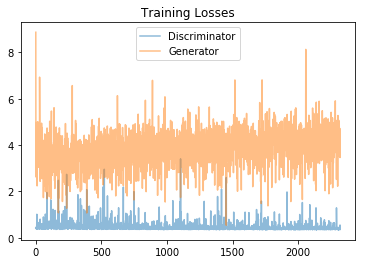

In [41]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [42]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [43]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

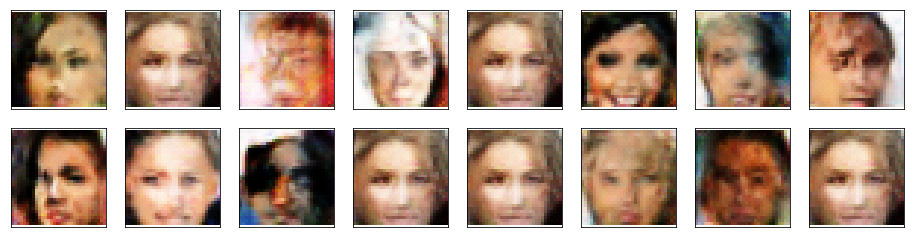

In [44]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** Considering the bias of the train images, it is clear that the resulting faces are not very diverse. I think having a broader range of faces could make for a more interesting result. The resulting model might even produce more realistic images.

Considering that my model is not especially complex, it is also not surprising that the generated images are not especially convincing. Additionally the images are low in quality. I think a more complex model, with a higher output size could be interesting, though computationally challenging.

On epochs, after testing a simple Generator on a single epoch, the generated images were not very nice to look at. Though, if you squint, they do resemble human faces. After 100 epochs on the same model, the faces appear corrupted not at all like faces, but all sharing many "features". I suspect the Generator will not reach an optimal solution.

A more complex model produced better single epoch results, but after 20 epochs, the outcome was similarly not optimal.

A similarly complex model, with fewer conv dimensions (down to 64 from 256) using binary cross entropy loss, with smoothing (previously, mean squared error, no smoothing) produces the decent results after 5 epochs, snd seems to have resolved the corruption issue. After 50 epochs corruption issue returns. Note: D loss is much lower than G loss.

A simplified D produced identical results at 5 (compared to prev model, 5 epochs) epochs, but the G and D loss appear more natural. After 50 epochs, uncorrupted, but unconvincing faces are generated.

Asimplified D, with tweaked hyperparams, batch 96=>64, shows good signs at 40 epochs. At 80 epochs, the outcome is passable, though not impressive. Some faces look realistic.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.